In [1]:
!mkdir -p data/sberbank-russian-housing-market

In [2]:
!unzip -o data/sberbank-russian-housing-market.zip -d data/sberbank-russian-housing-market

Archive:  data/sberbank-russian-housing-market.zip
  inflating: data/sberbank-russian-housing-market/data_dictionary.txt  
  inflating: data/sberbank-russian-housing-market/macro.csv.zip  
  inflating: data/sberbank-russian-housing-market/sample_submission.csv.zip  
  inflating: data/sberbank-russian-housing-market/test.csv.zip  
  inflating: data/sberbank-russian-housing-market/train.csv.zip  


In [3]:
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn import svm
from sklearn.metrics import RocCurveDisplay, auc
from sklearn.model_selection import StratifiedKFold
from tqdm.notebook import tqdm

seed = np.random.RandomState(31337)

In [4]:
z = zipfile.ZipFile("data/sberbank-russian-housing-market/train.csv.zip")
z.extractall("data/sberbank-russian-housing-market/")

t = zipfile.ZipFile("data/sberbank-russian-housing-market/test.csv.zip")
t.extractall("data/sberbank-russian-housing-market/")

In [5]:
train = pd.read_csv("data/sberbank-russian-housing-market/train.csv")

train.shape

(30471, 292)

In [6]:
test = pd.read_csv("data/sberbank-russian-housing-market/test.csv")

test.shape

(7662, 291)

In [7]:
train.columns

Index(['id', 'timestamp', 'full_sq', 'life_sq', 'floor', 'max_floor',
       'material', 'build_year', 'num_room', 'kitch_sq',
       ...
       'cafe_count_5000_price_2500', 'cafe_count_5000_price_4000',
       'cafe_count_5000_price_high', 'big_church_count_5000',
       'church_count_5000', 'mosque_count_5000', 'leisure_count_5000',
       'sport_count_5000', 'market_count_5000', 'price_doc'],
      dtype='object', length=292)

In [8]:
# drop target variable from our training dataset
X_train = train.drop(["price_doc"], axis=1)

In [9]:
X_train["adval_label"] = 1.0

In [10]:
test["adval_label"] = 0.0

In [11]:
# combine training & test datasets
combined_dataset = pd.concat([X_train, test], axis=0, ignore_index=True)

combined_dataset.shape

(38133, 292)

In [12]:
combined_dataset.columns

Index(['id', 'timestamp', 'full_sq', 'life_sq', 'floor', 'max_floor',
       'material', 'build_year', 'num_room', 'kitch_sq',
       ...
       'cafe_count_5000_price_2500', 'cafe_count_5000_price_4000',
       'cafe_count_5000_price_high', 'big_church_count_5000',
       'church_count_5000', 'mosque_count_5000', 'leisure_count_5000',
       'sport_count_5000', 'market_count_5000', 'adval_label'],
      dtype='object', length=292)

In [13]:
# convert non-numerical columns to integers
combined_dataset_numeric = combined_dataset.select_dtypes(exclude=["object"])
combined_dataset_obj = combined_dataset.select_dtypes(include=["object"]).copy()

for c in combined_dataset_obj:
    combined_dataset_obj[c] = pd.factorize(combined_dataset_obj[c])[0]

In [14]:
combined_dataset = pd.concat([combined_dataset_numeric, combined_dataset_obj], axis=1)

In [15]:
# shuffle it
combined_dataset_shuffled = combined_dataset.sample(frac=1)

In [16]:
X = combined_dataset_shuffled.drop(["adval_label"], axis=1)

In [17]:
X = X.drop(["id", "timestamp"], axis=1)

In [18]:
y = combined_dataset_shuffled["adval_label"]

In [19]:
n_splits = 6
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
classifier = xgb.XGBClassifier()

  0%|          | 0/6 [00:00<?, ?it/s]

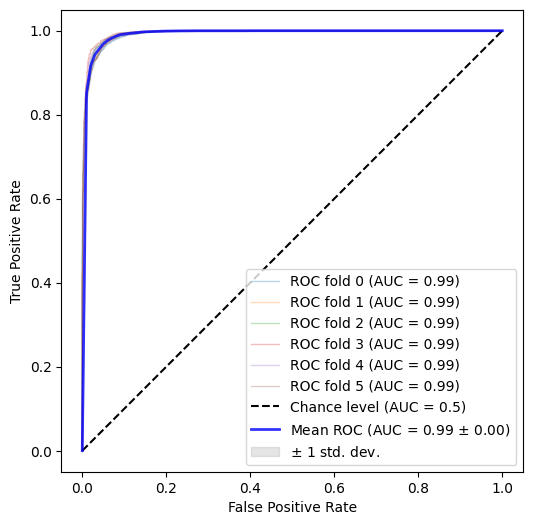

In [20]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(6, 6))


for fold, (train, test) in tqdm([*enumerate(cv.split(X, y))]):
    classifier.fit(X.iloc[train], y.iloc[train])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X.iloc[test],
        y.iloc[test],
        name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax,
        plot_chance_level=(fold == n_splits - 1),
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
)
ax.axis("square")
ax.legend(loc="lower right")
plt.show()

In [21]:
aucs

[0.9922806963986244,
 0.9928696678617237,
 0.9938467900207265,
 0.9947494882495559,
 0.9943766051476374,
 0.9917432917281328]